# Updates
1. Now added GPU. Improves total training time from 4 hrs to 13 mins!
2. Visualising GAN output after every epoch of training to see how the model is doing over time.

# Introduction

Making Classifiers on the MNIST Database is fun, and seeing your model recognize digits as well as you is quite cool. But even cooler is when your model can write! In this notebook, I will be making 2 different GANs: FCGAN (Fully Connected GAN), as well as a DCGAN (Deep convolution GAN). 

I hope you find this tutorial helpful. I have tried to give a step by step explanation for each line of code. Feel free to fork the notebook and change the database to see your model create other pictures

* Also, this article was a real help for this: https://medium.com/analytics-vidhya/implementing-a-gan-in-keras-d6c36bc6ab5f, so make sure to show your appreciation there as well.


# A Simple Understanding of GANs

GAN stands for Generative Adversarial Network, and they are used for generating images. 

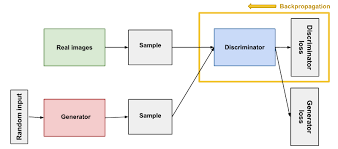

As seen form the picture, a GAN has essentially 2 parts:

1. The Generator: This generator takes in a noisy vector as input (random numbers), and tries to generate a picture. Obviously, the intitial images will be noise, so how do we train this network? That's where the discriminator comes in.

2. The Discriminator: The discriminator takes an image as input, and simply tries to identify whether it is fake (generated by the GAN) or real (from our dataset of images).

Now we essentially set up a game between the two, where each tries to outperform the other.

The Discriminator tries to do its best job in catching GANs, so even small deformations in the image will be noticed by this.
The Generator tries to fool the discriminator, in turn making more and more realistic images.

As the two keep learning, both get better. Once we are done training, we just take the generator part of the model, and feed it a random noise vector, and it generates realistic images!

I am using the MNIST (digit and fashion) database to keep the training simple. In practice, you could use other kinds of datasets as well.

Also, there are lots of different GANs for different kinds of tasks. Below are a few:


1. FCGAN - This is just a simple GAN (described above), where you use Dense layers and standard sequential models for generation. These are not very powerful. I will cover this in this notebook.

2. DCGAN - This is another simple GAN, which involves using convolutional layers in the GAN, and these are much more powerful at generating images. I will cover this as well.

3. Cycle GAN - Cycle GANs are used when you want to take an image as input, and morph a particular part of it. For example, if we want to convert all apples in an image to oranges, we would use a cycle GAN. It is called a cycle GAN as the GAN has an extra part where it has to reconstruct the original image. This is done purely so that the GAN only changes the apples to oranges and not the entire background, etc.

4. Sytle GAN - This was developed by NVIDIA to make super realistic faces (and cars and bedrooms). If you check their results, you would be suprised at how realistic they are!). You can even use their pre trained model to develop some results!

And the list goes on... Lot's of interesting stuff can be done with GANs, and even dangerous things (such as deepfaking videos of political leaders). But I won't get into that. 

To get a better understanding of the loss function involved and the backpropagation changes, have a look at this lecture: 
https://youtu.be/ANszao6YQuM?list=PLoROMvodv4rOABXSygHTsbvUz4G_YQhOb&t=2766



Now that we understand GANs, let's move on. First, let's import some libraries (there are other imports in other code blocks), and also set up some constants. I will explain each line of code, step by step with comments.

First let's see if the GPU is enabled.

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Let's make sure tensorflow is doign all of it's operations on the GPU, and not the CPU

In [ ]:
tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

Great, so now the GPU is working, and should speed up our computations.

In [ ]:
#Initialising Hyper Parameters

#Uncomment one of the two below lines. For some reason, on some computers the first one works, while on others the second.
from tensorflow.keras.optimizers import Adam
#from keras.optimizers import adam
import tensorflow as tf

import numpy as np
import keras

np.random.seed(10)  #for consistency of random numbers and our images

noise_dim = 100  # input dimension of random vector - the vector that goes into the generator

batch_size = 16   #How many images do we want to include in each batch
steps_per_epoch = 3750  #How many steps do we want to take per iteration of our training set (number of batches)
epochs = 10      #How many iterations of our training set do we want to do.

#change the below values to the dimensions of your image. The channels number refers to the number of colors
img_rows, img_cols, channels = 28, 28, 1

#These are the recommended values for the optimizer
optimizer = Adam(0.0002, 0.5)


In [ ]:
#importing mnist dataset (dataset to mimick), also reshaping the data for preprocessing

#You can import the mnist digit dataset, or the fashion MNIST dataset. For FCGAN, mnist digit works better because it is simpler than the fashion dataset.
from keras.datasets import mnist
#from keras.datasets import fashion_mnist

import os

(x_train, y_train), (x_tet, y_test) = mnist.load_data()     #loading data

x_train = (x_train.astype(np.float32) - 127.5) / 127.5      #Nomralizing the data so that it is from -1 to 1. NNs converge faster this way

x_train = x_train.reshape(-1, img_rows*img_cols*channels)    #The data is in an image style format, so we need to reshape it into a vector.


# FCGAN Implementation

An FCGAN is the same thing that I described above. First we will create a generator. Here I am just using 4 dense layers. The activation we will be using for the hidden layers will be LeakyReLU with a negative slope of 0.2 (The original paper recommended this activation).

Remember that the output layer has to have a tanh activation and not sigmoid because pixel values are from -1 to 1 (we normalized the data), not 0 to 1.

In [ ]:
#Starting to create FCGAN (fully connected GAN)

#creating generator portion of the GAN



from keras.models import Sequential
from keras.layers import Dense
from keras.layers.advanced_activations import LeakyReLU

def create_generator():
    generator = Sequential()

    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(img_rows*img_cols*channels, activation='tanh'))  #The output layer has the same number of neurons as pixels in the image, because each neuron produces the color value for each pixel
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer) # A standard cross entropy loss would work, because the feedback it is getting is whether it fooled the discriminator or not.
    
    return generator
    

The discriminator will also use the same format, except the number of neurons will be different. This is not a very bulky generator just to keep the training quicker.

In [ ]:
#creating the discriminator for the GAN

def create_discriminator():
    discriminator = Sequential()
    
    discriminator.add(Dense(1024, input_dim=img_rows*img_cols*channels))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(1, activation='sigmoid'))  #sigmoid activation as output is 0/1 fake/real
    
    discriminator.compile(loss='binary_crossentropy', optimizer = optimizer)  #Binary Cross entropy loss as the discriminator has to try and classify all images (real or fake) in the right category
    
    return discriminator

In this step, we will combine the generator and the discriminator. The reason is that the loss (feedback on whether the generator was good) has to flow from the discriminator. 

In [ ]:
#combining the generator and discriminator to make a single large gan (loss and derivatives have to flow from discriminator to generator)

from keras.layers import Input
from keras.models import Model

discriminator = create_discriminator()   #Creating the discriminator using the function
generator = create_generator()           #Creating the generator using the function

discriminator.trainable = False          #We will set this to false, so that when we train the entire GAN together, only the generator part will be trained. We will train the discriminator separately. See below code block for more details.

gan_input = Input(shape=(noise_dim,))    #We set the input of the whole model as the noise vector that the generator takes in as input. This is because the generator first has to develop an image for training to start.
fake_image = generator(gan_input)        #Image generated by GAN for this noise vector is stored in fake_image

gan_output = discriminator(fake_image)   #The output of the GAN is the discriminator

gan = Model(gan_input, gan_output)       #Finally putting the generator and discriminator together
gan.compile(loss='binary_crossentropy', optimizer=optimizer)  # Using binary cross entropy loss (same as discriminator loss)


Here is where we finally train the GAN. The first for loop is meant for the number of epochs (iterations over training set). The second for loop is to split the training set into the number of batches we chose. I have also printed the loss for the discriminator and generator after every epoch.

Note that the below code block is quite bulky and takes a long time to run.

In [ ]:
#Code for plotting results
import matplotlib.pyplot as plt

def show_images(noise, size_fig):
    generated_images = generator.predict(noise)   #Create the images from the GAN.
    plt.figure(figsize=size_fig)
    
    for i, image in enumerate(generated_images):
        plt.subplot(size_fig[0], size_fig[1], i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')    #If the image is grayscale, as in our case, then we will reshape the output in the following way.
                                                                            #Also, we set the coloring to grayscale so that it doesn't look like it came out of an infrared camera :)
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()   #Tight layout so that all of the generated images form a nice grid
    plt.show()

In [ ]:
for epoch in range(epochs):         #iterate the dataset for the number of epochs
    for batch in range(steps_per_epoch):    #for the number of batches we wanted to create
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))   #We generate a new noise vector to feed the generator before every training iteration
        fake_x = generator.predict(noise)        #The image the generator develops for the noise vector we created above

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]  #We won't use all real images from our dataset at once, we will only select a random sample of images
        
        x = np.concatenate((real_x, fake_x))    #making the x dataset for the discriminator. This includes a mix of real and fake examples for the discriminator to correctly classify

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)   #We are training the discriminator separately. Remember, we set trainable = false when adding it to the GAN, so that when we train the GAN, we only train the generator. Hence this extra step

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)       #Now we train the entire GAN. But since the discriminator can't be trained, only the generator is trained in this step.

    print(f'Epoch: {epoch + 1} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    noise = np.random.normal(0, 1, size=(25, noise_dim))
    show_images(noise, (5, 5))

Finally, we finished training the GAN. We can see that over time, the GAN is definitely getting better. Blurry digits are becoming rarer, and the rest of the images are also getting sharper. Great! Let's just plot the results once again but with more images.

In [ ]:
noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise)

Wow. The images do look really good. However, some of the aprts of numbers (like the 8) are slightly faded in some regions. This is partly because of how many epochs, but also because we are using an FCGAN. Using a DCGAN would give much better results... which is what we are going to do next!

# DCGAN Implementation

DCGANs are extremely similar to FCGANs. The only difference is that we add convolutional layers into the generator and the discriminator. As we saw in these datasets already, convolutional neural networks can better understand images than standard NNs. We are going to use this same understanding here so that we can generate much better and more clear images. To show the full power of the DCGAN, I will be switching over to the fashion MNIST database, but you can use the MNIST digit recognizer database as well.

In [ ]:
#Choose from one of the below datasets
from keras.datasets import fashion_mnist
#from keras.datasets import mnist

import os

(x_train, y_train), (x_tet, y_test) = fashion_mnist.load_data()   #Load the data

x_train = (x_train.astype(np.float32) - 127.5) / 127.5       #Normalize the images again so that the pixel value is from -1 to 1

x_train = x_train.reshape(-1, img_rows, img_cols, channels)  #Reshaping the data into a more NN friendly format

Ok, so now we are going to create the generator for the DCGAN. Instead of all of the dense layers, we will be using Conv2D and Conv2D Transpose layers. Also, you can't just add new Conv2D Transpose layers like you can for the FCGAN, since the dimensions would change and the output won't be the same resolution as the image, you would need to reshape the data accordingly.

In [ ]:
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential


def create_generator_cgan():
    generator = Sequential()
    
    d = 7
    generator.add(Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))     #We are going to use the same leaky relu activation function as the FCGAN.
    
    generator.add(Reshape((d, d, 256)))
    
    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    

    
    generator.add(Conv2D(channels, (3, 3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))  #Remember that the final activation has to be tanh, since pixel values go from -1 to 1
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)    #The loss doesn't change when you use convolutional layers
    return generator

Now we are going to make a discriminator. Since we are using convolutional layers, this model is going to look very similar to a standard Convolutional NN. The difference is that instead of classifying the class of the image, we are going to be classifying whether an image is real or fake.

In [ ]:
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential

def create_discriminator_cgan():
    discriminator = Sequential()
    
    discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid', input_shape=(img_cols, img_rows, channels)))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)  #Again, the loss doesn't change when creating a DCGAN.
    return discriminator

Now that we have changed the generator and discriminator, let's compile them into a single model. This code block is similar to the one used for FCGAN, because they way you join these models (and let the losses flow back) is the same.

In [ ]:
from keras.layers import Input
from keras.models import Model

discriminator = create_discriminator_cgan()
generator = create_generator_cgan()

discriminator.trainable = False

gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

The fashion MNIST database is more complex than tha standard digit MNIST database. This is because a shoe in the database is very different from a shirt, and these all have complex shapes. Hence, for making the life of the model simpler, I will only be generating T-shirts. The next code block basically limits the training data to only shirts. This makes the model learn to generate images better in fewer epochs (including all classes generates relatively low quality images).

In [ ]:
x_train = x_train[np.where(y_train == 0)[0]]

Now, let's just plot a shirt to see how it looks before we train the model and see it's outputs

In [ ]:
image = x_train[29]
plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')

Again, this code is very similar to the previous one for the FCGAN. This is because the training procedure is also the same. The only fundamental difference is the convolutional layers. This code block takes some time to run. If you use a GPU, it's much faster.
Also, remember that we have already defined the show_images function above. Go back to remind yourself if needed.

In [ ]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_x = generator.predict(noise)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
        #print(real_x.shape)
        #print(fake_x.shape)
        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f'Epoch: {epoch + 1} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    noise = np.random.normal(0, 1, size=(25, noise_dim))
    show_images(noise, (5, 5))

Again, we can see that the model is learning quite well over time. Now let's just generate a larger sample of images.

In [ ]:
noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise, (10, 10))

Wow, the results are amazing. Some of the shirts look just like the ones in the database. There are a few faults, however, like one sleeve being longer than the other, but that is because we trained it for a smaller duration.

# Extensions

This is just the basic implementation of a GAN using keras. There are a lot of research papers out there on how to improve the performance of such GANs, which you should try and check out.

Also, try forking this notebook and running it on the CIFAR -10 dataset, and see if you can generate color images! It isn't very hard to implement: you just need to change the dataset, and the number of channels to 3.

You can also experiment with other GANs such as Cycle GANs and Style GANs. This is still a growing area of research but I find it quite interesting that my computer can already draw better shirts than me!

Also, I will try to update this notebook (based on the turnout).

Thanks for reading the entire notebook. If you liked it, please upvote :). And please leave some feedback in the comments. I will try to make this notebook better.